In [13]:
import numpy as np
import cv2
import imutils

from matplotlib import pyplot as plt
from imutils import perspective, contours
from scipy.spatial import distance as dist
from skimage.filters import threshold_local

In [14]:
# real world object size
reference_size_cm = (24, 31) 

def midpoint(point_a, point_b):
    return (
        (point_a[0] + point_b[0]) / 2,
        (point_a[1] + point_b[1]) / 2
    )

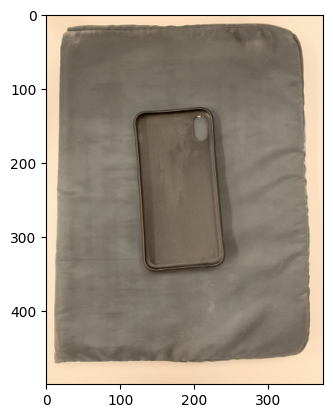

In [15]:
image = cv2.imread('./samples/measure_sample29.jpg')
orig = image.copy()
image = imutils.resize(image, height=500)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

88.02012970666667 177.37389774222223


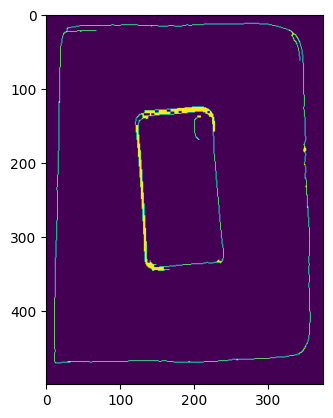

In [16]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (3,3), 0)

lower = 0.66 * np.mean(image)
upper = 1.33 * np.mean(image)
print(lower, upper)
edged = cv2.Canny(blur, lower, upper)
edged = cv2.dilate(edged, None, iterations=1) 
edged = cv2.erode(edged, None, iterations=1)

plt.imshow(edged)



In [17]:
cnts = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
# cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
cnts, _ = contours.sort_contours(cnts, 'bottom-to-top')

(500, 375, 3)


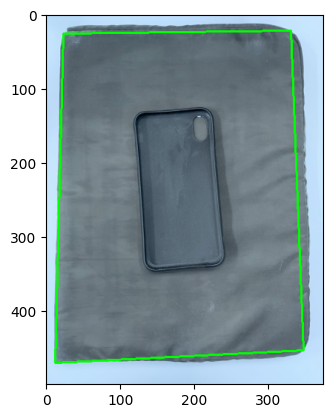

In [18]:
img = image.copy()

background_cnt = None
background_cnt_index = -1
for index, c in enumerate(cnts): 
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    
    if len(approx) == 4:
        background_cnt = approx
        background_cnt_index = index
        break

if background_cnt is None:
    print('reference object not found')
cv2.drawContours(img, [background_cnt], -1, (0,255,0), 2)
plt.imshow(img)
print(img.shape)


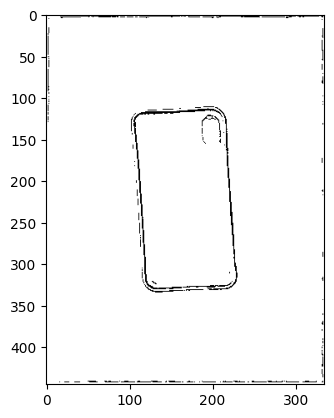

In [19]:
warped = perspective.four_point_transform(img, background_cnt.reshape(4,2))

warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
T = threshold_local(warped, block_size=11, offset=10, method='gaussian')
warped = (warped > T).astype('uint8') * 255
warped_img = cv2.cvtColor(warped, cv2.COLOR_GRAY2RGB)
plt.imshow(warped_img)

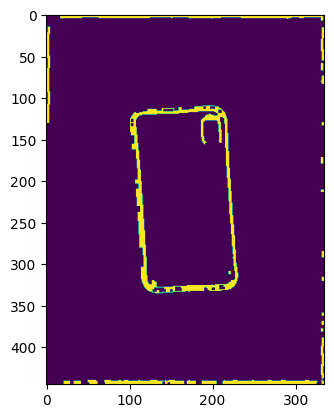

In [20]:
img = warped.copy()
blur = cv2.GaussianBlur(img, (3,3), 0)

lower = 0.66 * np.mean(img)
upper = 1.33 * np.mean(img)
edged = cv2.Canny(blur, lower, upper)
edged = cv2.dilate(edged, None, iterations=1) 
edged = cv2.erode(edged, None, iterations=1)

plt.imshow(edged)

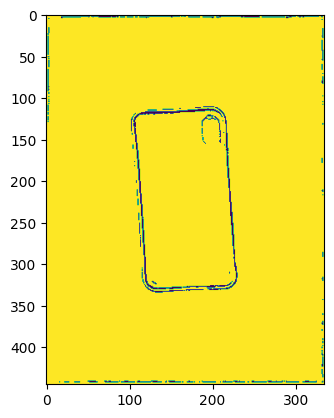

In [21]:
local_cnts = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
local_cnts = imutils.grab_contours(local_cnts)
local_cnts, _ = contours.sort_contours(local_cnts, 'left-to-right')

img_copy = img.copy()
for c in local_cnts:
    if cv2.contourArea(c) < 500:
        continue
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    box = np.array(box, dtype='int')
    
    cv2.drawContours(img_copy, [box], -1, (255,255,255))
    
plt.imshow(img_copy)
cnts = local_cnts


In [22]:

# sort coordinate from left to right, top to bottom
# calculate the width and height
box = perspective.order_points(background_cnt.reshape(4,2))

tl, tr, br, bl = box
tx, ty = midpoint(tl, tr)
bx, by = midpoint(bl, br)

tblx, tbly = midpoint(tl, bl)
tbrx, tbry = midpoint(tr, br)


h_dist = dist.euclidean((tx, ty), (bx, by))
w_dist = dist.euclidean((tblx, tbly), (tbrx, tbry))

w_cm_ratio = w_dist / reference_size_cm[0]
h_cm_ratio = h_dist / reference_size_cm[1]

size_ratio = (w_cm_ratio, h_cm_ratio)


print(size_ratio)


(13.382153460859726, 14.145492327019845)


size from minAreaRect: 7.0 315.0
size from coordinate calculation: 315.0 7.0
size from minAreaRect: 223.63233947753906 116.76611328125
size from coordinate calculation: 116.77435506137466 223.53802808470866


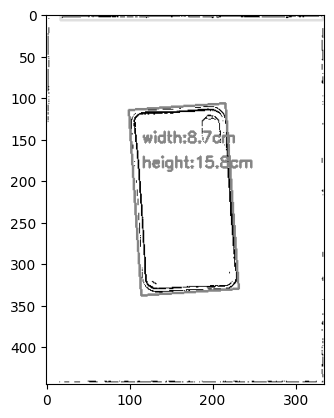

In [23]:


from random import randint


# size_ratio = None
img = warped.copy()
for index, c in enumerate(cnts):
    if cv2.contourArea(c) < 500 or index == background_cnt_index:
        continue
    
    rect = cv2.minAreaRect(c)
    (x,y), (w, h), angle = rect 
    box = cv2.boxPoints(rect)
    box = np.array(box, dtype='int')
    
    # prefer calculate width and height from coordinate than get from minAreaRect
    # it can roughly ignore the object rotation
    order_box = perspective.order_points(box.reshape(4,2))
    tl, tr, br, bl = order_box
    tx, ty = midpoint(tl, tr)
    bx, by = midpoint(bl, br)

    tblx, tbly = midpoint(tl, bl)
    tbrx, tbry = midpoint(tr, br)


    h_dist = dist.euclidean((tx, ty), (bx, by))
    w_dist = dist.euclidean((tblx, tbly), (tbrx, tbry))
    
    print('size from minAreaRect:', w, h)
    print('size from coordinate calculation:',w_dist, h_dist)
    
    w_cm = w_dist / size_ratio[0]
    h_cm = h_dist / size_ratio[1]
    
    color = (randint(0,255), randint(0,255), randint(0,255))
    cv2.putText(img, 'width:{:.1f}cm'.format(w_cm), (int(x - 50), int(y - h/2 - 10)), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    cv2.putText(img, 'height:{:.1f}cm'.format(h_cm), (int(x - 50), int(y - h/2 + 20)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    cv2.drawContours(img, [box], -1, color, 2)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))